In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

#### 1. DTW

In [2]:
def dtw(x, y):
    # Size of Each Time Series
    # -------------------------------------------------------------------------------------------
    n = len(x)
    m = len(y)

    # Local Cost Matrix (Dissimilarities)
    # -------------------------------------------------------------------------------------------
    dist = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dist[i,j] = (x[j]-y[i])**2  # Euclidean distance


    # Accumulated Cost Matrix
    # -------------------------------------------------------------------------------------------
    dtw_cost = np.zeros((m, n))
    dtw_cost[0,0] = dist[0,0]
    for i in range(1, n): # update y-axis
        dtw_cost[0,i] = dist[0,i] + dtw_cost[0, i-1]
    for i in range(1, m): # update x-axis
        dtw_cost[i,0] = dist[i, 0] + dtw_cost[i-1, 0] 
    for i in range(1, m):
        for j in range(1, n):
            dtw_cost[i, j] = min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]) + dist[i, j]

    # Warping Path
    # -------------------------------------------------------------------------------------------
    i = m - 1
    j = n - 1
    path = [[n-1, m-1]]
    
    while i > 0 or j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if dtw_cost[i-1, j] == min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]):
                i = i - 1
            elif dtw_cost[i, j-1] == min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j = j- 1
        path.append([j, i])
    #path.append([0,0])

    # Return Dynamic Time Warping Distance
    # -------------------------------------------------------------------------------------------
    return dtw_cost[-1][-1], path

##### 1.1 DTW Example

In [3]:
# Simulate data
np.random.seed(12345)
x = np.sin(np.linspace(0, 4*np.pi, 60)) + np.random.uniform(size=60) / 5
y = np.cos(np.linspace(-np.pi, 3*np.pi, 60)) + np.random.uniform(size=60) / 5

n = len(x)
m = len(y)

7.772761608502307


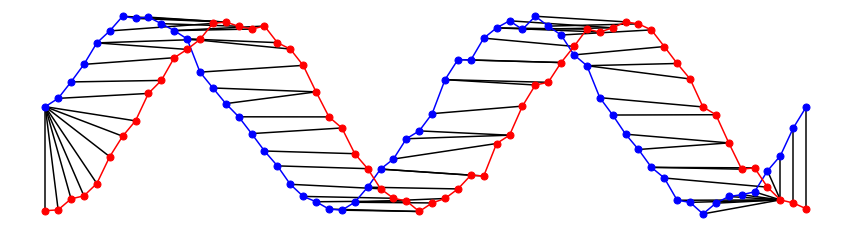

In [4]:
# Get the distance and warping path
distance, warp_path_dtw = dtw(x, y)
print(distance)

# Plot the times series and the paths
fig, ax = plt.subplots(figsize=(15, 4))

# Remove the border and axes ticks
#fig.patch.set_visible(False)
ax.axis('off')
for [map_x, map_y] in warp_path_dtw:
    ax.plot([map_x, map_y], [x[map_x], y[map_y]], '-k')

ax.plot(x, color='blue', marker='o', markersize=7)
ax.plot(y, color='red', marker='o', markersize=7)
ax.tick_params(axis='both', which='major', labelsize=18)

#### 2. Weighted DTW

For WDTW, the weighting function is modified logistic function (MLWF). The weight value $w_{(i)}$ is defined as 

$$w_{(i)} = \frac{w_{\max}}{1+\exp(-g(i-m_c)}$$

where $i = 1, \dots, m$, $m$ is the length of a sequence and $m_c$ is the midpoint of the sequence.

The $w_{\max}$, which is used to set the maximum of weight values, does not influence on the accuracy of experimental results because weight is positive and
$w_{\max}$ represents the full scale of weights in MLWF. Regardless of $w_{\max}$ value, MLWF retains its shape, implying that MLWF assigns weights with constant ratios to points in a sequence.

In [5]:
def wdtw(x, y, w_max=1, g=0.2):
    #  Size of Each Time Series
    # -------------------------------------------------------------------------------------------
    n = len(x)
    m = len(y)

    # Local Cost Matrix (Dissimilarities)
    # -------------------------------------------------------------------------------------------
    dist = np.zeros((m, n))
    weight_vectors = w_max/(1 + np.exp(-g * (np.arange(1, m+1) - (m+1)/2)))
    for i in range(m):
        for j in range(n):
            dist[i,j] = weight_vectors[i] * (x[j]-y[i])**2
    
    # Accumulated Cost Matrix
    # -------------------------------------------------------------------------------------------
    dtw_cost = np.zeros((m, n))
    dtw_cost[0,0] = dist[0,0]
    for i in range(1, n): # update y-axis
        dtw_cost[0,i] = dist[0,i] + dtw_cost[0, i-1]
    for i in range(1, m): # update x-axis
        dtw_cost[i,0] = dist[i, 0] + dtw_cost[i-1, 0] 
    for i in range(1, m):
        for j in range(1, n):
            dtw_cost[i, j] = min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]) + dist[i, j]

    # Warping Path
    # -------------------------------------------------------------------------------------------
    i = m - 1
    j = n - 1
    path = [[n-1, m-1]]
    
    while i > 0 or j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if dtw_cost[i-1, j] == min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]):
                i = i - 1
            elif dtw_cost[i, j-1] == min(dtw_cost[i-1, j-1], dtw_cost[i-1, j], dtw_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j = j - 1
        path.append([j, i])
    #path.append([0,0])

    # Return Weighted Dynamic Time Warping Distance
    # -------------------------------------------------------------------------------------------
    return dtw_cost[-1][-1], path

2.3035595945111336


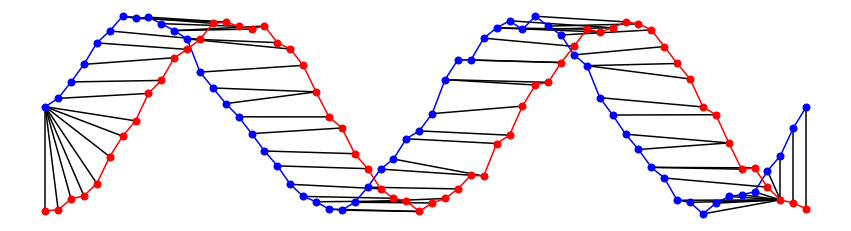

In [6]:
# Get the distance and warping path
distance, warp_path_wdtw = wdtw(x, y, w_max=1.0, g=0.4)
print(distance)

# Plot the times series and the paths
fig, ax = plt.subplots(figsize=(15, 4))

# Remove the border and axes ticks
#fig.patch.set_visible(False)
ax.axis('off')
for [map_x, map_y] in warp_path_wdtw:
    ax.plot([map_x, map_y], [x[map_x], y[map_y]], '-k')

ax.plot(x, color='blue', marker='o', markersize=7)
ax.plot(y, color='red', marker='o', markersize=7)
ax.tick_params(axis='both', which='major', labelsize=18)

In [7]:
# Get the difference of two paths of DTW and WDTW
diff_dict = {}

# Compute the difference from warp_path_dtw to warp_path_wdtw
diff_arr1 = set(map(tuple, warp_path_dtw)) - set(map(tuple, warp_path_wdtw))
diff_dict['warp_path_dtw'] = sorted(list(map(list, diff_arr1)), key=lambda x: (x[1], x[0]))

# Compute the difference from warp_path_wdtw to warp_path_dtw
diff_arr2 = set(map(tuple, warp_path_wdtw)) - set(map(tuple, warp_path_dtw))
diff_dict['warp_path_wdtw'] = sorted(list(map(list, diff_arr2)), key=lambda x: (x[1], x[0]))
diff_dict

{'warp_path_dtw': [[4, 12], [5, 13], [6, 14], [26, 34], [27, 35], [28, 36]],
 'warp_path_wdtw': [[5, 12], [6, 13], [27, 34], [28, 35]]}

#### 3. URC Time Series Data

In [8]:
# Read data from file
dataSet = np.loadtxt('dataSet_URC.txt')
initalClusters = dataSet[:,0]
dataSet = dataSet[:,1:]

(N, p) = dataSet.shape # set N as number of time series and p the length of time series
print('number of time series: %i ' %N)
print('length of time series: %i ' %p)

number of time series: 100 
length of time series: 96 


In [9]:
# Start timer to compute runtime
start_time = time.time()
# Compute DTW distance between all pairs in dataset
print('computing dtw distance matrix...')

distance_matrix_dtw = np.empty((N, N)) # N: number of time series in dataset
distance_matrix_dtw.fill(0)
for i in range(N):
    for j in range(i,N):
        distance_matrix_dtw[i][j] = dtw(dataSet[i,:],dataSet[j,:])[0]
        distance_matrix_dtw[j][i] = distance_matrix_dtw[i][j]
#np.savetxt('distance_matrix_dtw.txt', distance_matrix_dtw)

# Print runtime
print('dtw runtime is equal to: %s seconds' % round((time.time() - start_time), 2))

computing dtw distance matrix...
dtw runtime is equal to: 86.5 seconds


In [10]:
# Start timer to compute runtime
start_time = time.time()
# Compute WDTW distance between all pairs in dataset
print('computing wdtw distance matrix...')

weight_vector = np.random.rand(p)
weight_vector = weight_vector / np.sum(weight_vector) # random weighting
distance_matrix_wdtw = np.empty((N, N)) # N: number of time series in dataset
distance_matrix_wdtw.fill(0)
for i in range(N):
    for j in range(i,N):
        distance_matrix_wdtw[i][j] = wdtw(dataSet[i,:], dataSet[j,:], weight_vector)[0]
        distance_matrix_wdtw[j][i] = distance_matrix_wdtw[i][j]
#np.savetxt('distance_matrix_wdtw.txt', distance_matrix_wdtw)

# Print runtime
print('wdtw runtime is equal to: %s seconds' % round((time.time() - start_time), 2))

computing wdtw distance matrix...
wdtw runtime is equal to: 105.45 seconds


In [11]:
pd.DataFrame({
    'min_value': pd.DataFrame(distance_matrix_wdtw).apply(lambda x: np.min(x[x != 0]), axis=1), 
    'col_name': pd.DataFrame(distance_matrix_wdtw).apply(lambda x: x[x != 0].idxmin(), axis=1)
})

,min_value,col_name
0,0.002275,66
1,0.004356,3
2,0.007447,97
3,0.001497,37
4,0.013087,63
...,...,...
95,0.002072,8
96,0.002722,73
97,0.003263,59
98,0.002366,8
